# Deep Autoencoding Gaussian Mixture Model for Unsupervised Anomaly Detection

In [ ]:
import numpy as np 
import pandas as pd
import torch
from data_loader import *
from main import *
from tqdm import tqdm

## KDD Cup 1999 Data (10% subset)
This is the data set used for The Third International Knowledge Discovery and Data Mining Tools Competition, which was held in conjunction with KDD-99 The Fifth International Conference on Knowledge Discovery and Data Mining. The competition task was to build a network intrusion detector, a predictive model capable of distinguishing between "bad" connections, called intrusions or attacks, and "good" normal connections. This database contains a standard set of data to be audited, which includes a wide variety of intrusions simulated in a military network environment. 

In [ ]:
normalized_data = pd.read_feather('normalized_one_hot_encoded_data_Charlie.ftr')
normalized_data

,FUND_TYPE_0,FUND_TYPE_1,FUND_TYPE_2,FUND_TYPE_3,FUND_TYPE_4,FUND_TYPE_5,FUND_TYPE_6,FUND_TYPE_7,FUND_TYPE_8,FUND_TYPE_9,...,days_224,days_225,days_226,days_227,days_228,AMOUNT,INTEREST_VALUE,QUANTITY,TRANSACTIONCANCELLED,COST
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.299801,0.5,0.496066,1,0.43047
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.299801,0.5,0.496066,1,0.43047
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.299801,0.5,0.496066,0,0.43047
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.299801,0.5,0.496066,1,0.43047
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.299801,0.5,0.496066,1,0.43047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182964,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0.299801,0.5,0.496066,0,0.43047
2182965,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.299801,0.5,0.496127,0,0.43047
2182966,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.299801,0.5,0.496005,0,0.43047
2182967,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0.299801,0.5,0.496005,0,0.43047


In [ ]:
data = normalized_data

### Pre-processing
Following the paper, since the "normal" only comprises of approximately 20% of the entries, the "normal" data were considered as anomalies instead.

In [ ]:
data.loc[data["type"] != "normal.", 'type'] = 0
data.loc[data["type"] == "normal.", 'type'] = 1

Next, the categorical variables are converted to a one hot encoding representation. My implementation is a bit different from the original paper in this aspect. Since I am only using the 10% subset to generate the columns, I get 118 features instead of 120 as reported in the paper.

In [ ]:
one_hot_protocol = pd.get_dummies(data["protocol_type"])
one_hot_service = pd.get_dummies(data["service"])
one_hot_flag = pd.get_dummies(data["flag"])

data = data.drop("protocol_type",axis=1)
data = data.drop("service",axis=1)
data = data.drop("flag",axis=1)
    
data = pd.concat([one_hot_protocol, one_hot_service,one_hot_flag, data],axis=1)
data.head()

,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,1,0,0,0,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,1
1,0,1,0,0,0,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,1
2,0,1,0,0,0,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1
3,0,1,0,0,0,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1
4,0,1,0,0,0,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
proportions = data["TRANSACTIONCANCELLED"].value_counts()
print(proportions)
print("Anomaly Percentage",proportions[1] / proportions.sum())

0    2124953
1      58016
Name: TRANSACTIONCANCELLED, dtype: int64
Anomaly Percentage 0.026576648591894802


Normalize all the numeric variables.

In [ ]:
cols_to_norm = ["duration", "src_bytes", "dst_bytes", "wrong_fragment", "urgent", 
            "hot", "num_failed_logins", "num_compromised", "num_root", 
            "num_file_creations", "num_shells", "num_access_files", "count", "srv_count", 
            "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", 
            "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", 
            "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", 
            "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate" ]

# data.loc[:, cols_to_norm] = (data[cols_to_norm] - data[cols_to_norm].mean()) / data[cols_to_norm].std()
min_cols = data.loc[data["type"]==0 , cols_to_norm].min()
max_cols = data.loc[data["type"]==0 , cols_to_norm].max()

data.loc[:, cols_to_norm] = (data[cols_to_norm] - min_cols) / (max_cols - min_cols)

I saved the preprocessed data into a numpy file format and load it using the pytorch data loader.

In [ ]:
np.savez_compressed("kdd_cup",kdd=data.as_matrix())

I initially implemented this to be ran in the command line and use argparse to get the hyperparameters. To make it runnable in a jupyter notebook, I had to create a dummy class for the hyperparameters.

In [ ]:
class hyperparams():
    def __init__(self, config):
        self.__dict__.update(**config)
defaults = {
    'lr' : 1e-4,
    'num_epochs' : 200,
    'batch_size' : 1024,
    'gmm_k' : 4,
    'lambda_energy' : 0.1,
    'lambda_cov_diag' : 0.005,
    'pretrained_model' : None,
    'mode' : 'train',
    'use_tensorboard' : False,
    'data_path' : 'kdd_cup.npz',

    'log_path' : './dagmm/logs',
    'model_save_path' : './dagmm/models',
    'sample_path' : './dagmm/samples',
    'test_sample_path' : './dagmm/test_samples',
    'result_path' : './dagmm/results',

    'log_step' : 194//4,
    'sample_step' : 194,
    'model_save_step' : 194,
}

In [ ]:
!pip install torch==1.7 --user

  Using cached torch-1.7.0-cp38-cp38-manylinux1_x86_64.whl (776.8 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.10.1
    Uninstalling torch-1.10.1:
      Successfully uninstalled torch-1.10.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [Errno 16] Device or resource busy: '.nfsa71ebf3825b63d720000000c'



Elapsed 0:18:21.201638/0:00:00.085149 -- 0:00:00.085149 , Epoch [200/200], Iter [192/194], lr 0.0001, total_loss: 0.0452, sample_energy: -3.6939, recon_error: 0.0664, cov_diag: 69.6372


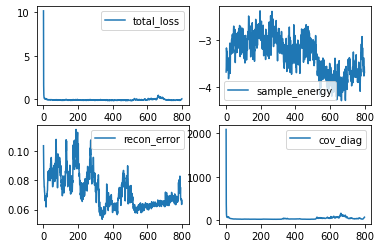

100%|██████████| 194/194 [00:05<00:00, 34.97it/s]

phi tensor([0.0188, 0.9391, 0.0226, 0.0195], device='cuda:0') mu tensor([[-0.1140,  1.0318,  0.1384],
        [ 0.0568,  0.8746,  0.4999],
        [-0.1275,  1.0445,  0.1095],
        [-0.1430,  1.0585,  0.0770]], device='cuda:0') cov tensor([[[ 0.1440, -0.1329,  0.3053],
         [-0.1329,  0.1228, -0.2819],
         [ 0.3053, -0.2819,  0.6473]],

        [[ 0.1184, -0.1090,  0.2506],
         [-0.1090,  0.1005, -0.2310],
         [ 0.2506, -0.2310,  0.5309]],

        [[ 0.1460, -0.1347,  0.3094],
         [-0.1347,  0.1244, -0.2856],
         [ 0.3094, -0.2856,  0.6559]],

        [[ 0.1468, -0.1355,  0.3112],
         [-0.1355,  0.1252, -0.2873],
         [ 0.3112, -0.2873,  0.6597]]], device='cuda:0')
======================TEST MODE======================


N: 198371
phi :
 tensor([0.0060, 0.9801, 0.0083, 0.0057], device='cuda:0',
       grad_fn=<DivBackward0>)
mu :
 tensor([[-0.2051,  1.1153, -0.0545],
        [ 0.0578,  0.8729,  0.5037],
        [-0.1539,  1.0681,  0.0541],
        [-0.1955,  1.1065, -0.0343]], device='cuda:0', grad_fn=<DivBackward0>)
cov :
 tensor([[[ 0.1385, -0.1279,  0.2944],
         [-0.1279,  0.1183, -0.2721],
         [ 0.2944, -0.2721,  0.6259]],

        [[ 0.1175, -0.1084,  0.2497],
         [-0.1084,  0.1001, -0.2304],
         [ 0.2497, -0.2304,  0.5305]],

        [[ 0.1449, -0.1338,  0.3080],
         [-0.1338,  0.1237, -0.2845],
         [ 0.3080, -0.2845,  0.6546]],

        [[ 0.1401, -0.1294,  0.2979],
         [-0.1294,  0.1197, -0.2752],
         [ 0.2979, -0.2752,  0.6332]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Threshold : -2.5435354709625244
Accuracy : 0.7817, Precision : 0.7026, Recall : 0.5833, F-score : 0.6375


In [ ]:
solver = main(hyperparams(defaults))
accuracy, precision, recall, f_score = solver.test()

### I copy pasted the testing code here in the notebook so we could play around the results.

### Incrementally compute for the GMM parameters across all training data for a better estimate

In [ ]:
solver.data_loader.dataset.mode="train"
solver.dagmm.eval()
N = 0
mu_sum = 0
cov_sum = 0
gamma_sum = 0

for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    phi, mu, cov = solver.dagmm.compute_gmm_params(z, gamma)
    
    batch_gamma_sum = torch.sum(gamma, dim=0)
    
    gamma_sum += batch_gamma_sum
    mu_sum += mu * batch_gamma_sum.unsqueeze(-1) # keep sums of the numerator only
    cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1) # keep sums of the numerator only
    
    N += input_data.size(0)
    
train_phi = gamma_sum / N
train_mu = mu_sum / gamma_sum.unsqueeze(-1)
train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

print("N:",N)
print("phi :\n",train_phi)
print("mu :\n",train_mu)
print("cov :\n",train_cov)

N: 198371
phi :
 tensor([0.0060, 0.9801, 0.0083, 0.0057], device='cuda:0',
       grad_fn=<DivBackward0>)
mu :
 tensor([[-0.2051,  1.1153, -0.0545],
        [ 0.0578,  0.8729,  0.5037],
        [-0.1539,  1.0681,  0.0541],
        [-0.1955,  1.1065, -0.0343]], device='cuda:0', grad_fn=<DivBackward0>)
cov :
 tensor([[[ 0.1385, -0.1279,  0.2944],
         [-0.1279,  0.1183, -0.2721],
         [ 0.2944, -0.2721,  0.6259]],

        [[ 0.1175, -0.1084,  0.2497],
         [-0.1084,  0.1001, -0.2304],
         [ 0.2497, -0.2304,  0.5305]],

        [[ 0.1449, -0.1338,  0.3080],
         [-0.1338,  0.1237, -0.2845],
         [ 0.3080, -0.2845,  0.6546]],

        [[ 0.1401, -0.1294,  0.2979],
         [-0.1294,  0.1197, -0.2753],
         [ 0.2979, -0.2753,  0.6332]]], device='cuda:0',
       grad_fn=<DivBackward0>)


In [ ]:
train_energy = []
train_labels = []
train_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, phi=train_phi, mu=train_mu, cov=train_cov, size_average=False)
    
    train_energy.append(sample_energy.data.cpu().numpy())
    train_z.append(z.data.cpu().numpy())
    train_labels.append(labels.numpy())


train_energy = np.concatenate(train_energy,axis=0)
train_z = np.concatenate(train_z,axis=0)
train_labels = np.concatenate(train_labels,axis=0)

### Compute the energy of every sample in the test data

In [ ]:
solver.data_loader.dataset.mode="test"
test_energy = []
test_labels = []
test_z = []
for it, (input_data, labels) in enumerate(solver.data_loader):
    input_data = solver.to_var(input_data)
    enc, dec, z, gamma = solver.dagmm(input_data)
    sample_energy, cov_diag = solver.dagmm.compute_energy(z, size_average=False)
    test_energy.append(sample_energy.data.cpu().numpy())
    test_z.append(z.data.cpu().numpy())
    test_labels.append(labels.numpy())


test_energy = np.concatenate(test_energy,axis=0)
test_z = np.concatenate(test_z,axis=0)
test_labels = np.concatenate(test_labels,axis=0)

In [ ]:
combined_energy = np.concatenate([train_energy, test_energy], axis=0)
combined_z = np.concatenate([train_z, test_z], axis=0)
combined_labels = np.concatenate([train_labels, test_labels], axis=0)

### Compute for the threshold energy. Following the paper I just get the highest 20% and treat it as an anomaly. That corresponds to setting the threshold at the 80th percentile.

In [ ]:
thresh = np.percentile(combined_energy, 100 - 20)
print("Threshold :", thresh)

Threshold : -2.734663963317871


In [ ]:
pred = (test_energy>thresh).astype(int)
gt = test_labels.astype(int)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score

In [ ]:
accuracy = accuracy_score(gt,pred)
precision, recall, f_score, support = prf(gt, pred, average='binary')

In [ ]:
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f}".format(accuracy,precision, recall, f_score))

Accuracy : 0.7710, Precision : 0.6963, Recall : 0.5392, F-score : 0.6077


## Visualizing the z space
It's a little different from the paper's figure but I assume that's because of the small changes in my implementation.

<IPython.core.display.Javascript object>


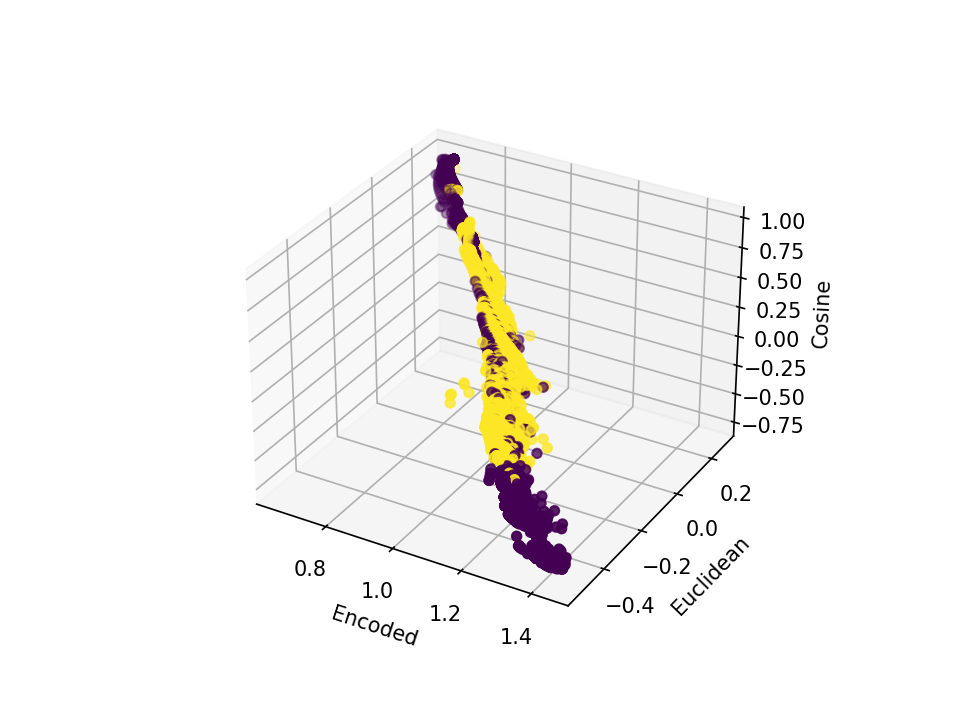

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_z[:,1],test_z[:,0], test_z[:,2], c=test_labels.astype(int))
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()